In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd

from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

from itertools import chain
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
from base import    double_control_predict_result,\
                    single_control_predict_result,\
                    gaolu_predict_raw,\
                    data_tranform_plot,\
                    get_y_aim_data,\
                    generate_yr,\
                    replace_outliers_with_weighted_diff

from base import MyRNNModel,CustomPredictor_double


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='单SI_0.2_0.8') 
# print(df_sheet_yuansu.info())
# print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean') 

# print(df_sheet_params.info())
# print(df_sheet_params.columns)



In [3]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量']
output_term = ['SI']
time_term= '时间戳h'


C:\Users\haokw\AppData\Local\Temp\ipykernel_16024\2527850494.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_16024\2527850494.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_16024\2527850494.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

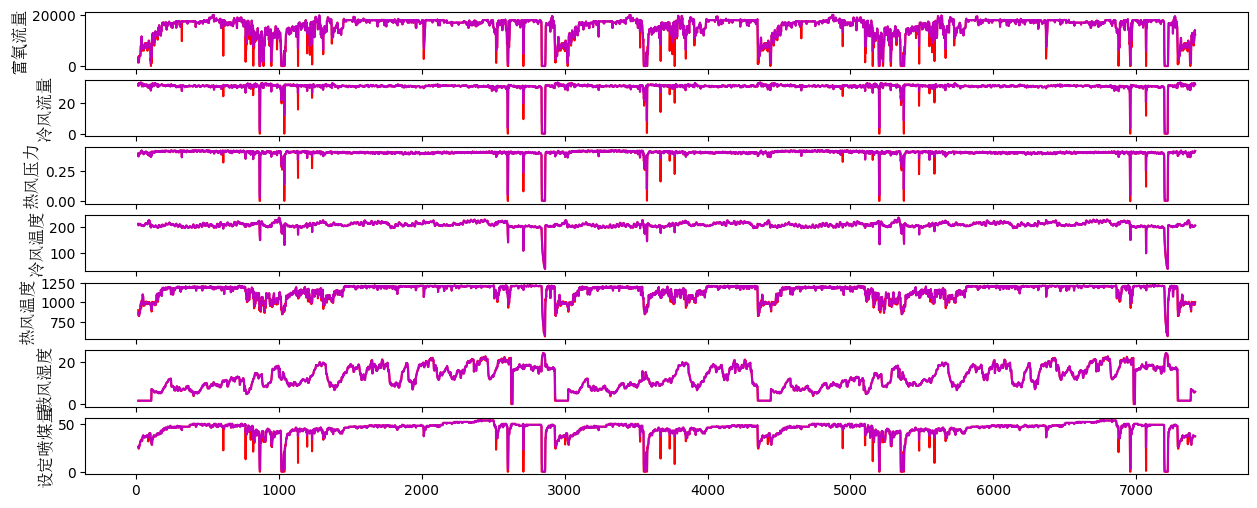

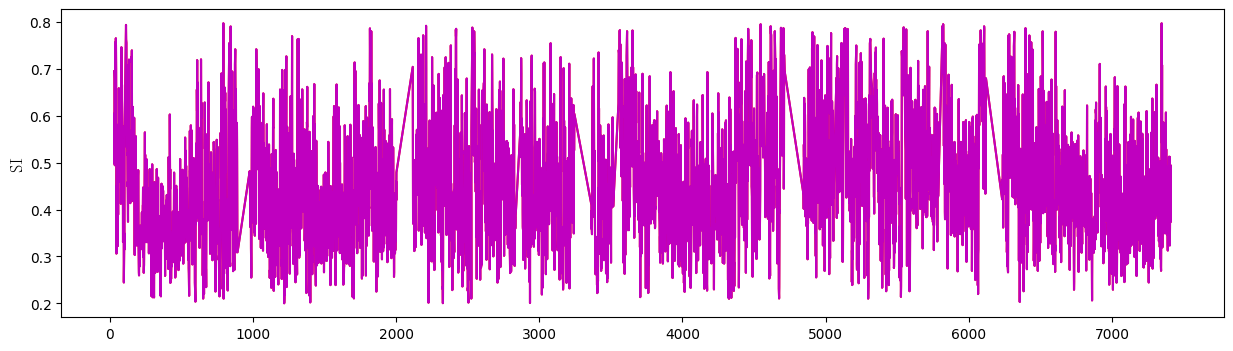

In [4]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

# replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
# replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

plt.figure(figsize=(15, 6))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

plt.figure(figsize=(15, 4))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




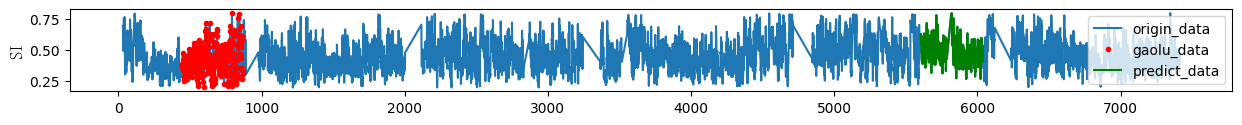

In [22]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 400
start1 = 400
length2 = 400
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)


In [23]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    input_term[4]:   df_sheet_params_process[input_term[4]].values,
    input_term[5]:   df_sheet_params_process[input_term[5]].values,
    input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [24]:
isShuffle = True
isShuffle = False
time_steps = 2
# 组合训练数据--拆分训练、测试集
test_size = 0.5
val_size = 0.001
train_size = 1-val_size-test_size


In [25]:
## 组合训练数据
# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,index_fanwei):
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data))
    y = y1_data

    X_modified = []
    y_modified = []
    
    for i in range(3,len(y1_data)):
        if i in index_fanwei:
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] <= yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            
            index = closest_10.index
            # print(index)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps + 1:
                print(i,yuansu_time,'errloss')
            else:

                # print(X[index, :])
                new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
                # print(new_x_sample)
                y_last = y[i-1]
                # print(y_last, 'y_last time : ',df_sheet_yuansu[time_term][i-1])
                new_x_sample = np.append(new_x_sample,y_last)
                # print(new_x_sample)
                y_sample = y[i]  
                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [26]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = y1_data
num_samples = y2_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = y1_data
num_samples = y2_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_predict)



高炉模型数据


Modified Input Shape: (401, 15)
Modified Output Shape: (401,)
训练数量： (199, 15) (199,)
验证数量： (1, 15) (1,)
测试数量： (201, 15) (201,)
预测模型数据
Modified Input Shape: (401, 15)
Modified Output Shape: (401,)
训练数量： (199, 15) (199,)
验证数量： (1, 15) (1,)
测试数量： (201, 15) (201,)


In [27]:
# 定义My_LS_SVRModel
class My_LS_SVRModel:
    def __init__(self, params):
        self.C = params[0]
        self.gamma = params[1]
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y, C):
            y_pred = np.dot(K_train, W_b[:-1]) + W_b[-1]
            errors = y - y_pred
            loss = 0.5 * np.dot(W_b[:-1], W_b[:-1]) + C * np.sum(errors**2)
            return loss

        initial_W_b = np.zeros(X_train.shape[0] + 1)
        result = minimize(objective, initial_W_b, args=(X_train, y_train, self.C), method='L-BFGS-B')
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def my_predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred = np.dot(K_test, self.W_b[:-1]) + self.W_b[-1]
        return y_pred
    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [28]:
def your_fitness_function(trial, params, X_train, y_train, X_test, y_test):
    # 示例用法
    # 创建模型
    my_svr_model = My_LS_SVRModel(params=params)
    # 训练模型
    my_svr_model.fit(X_train, y_train)
    # 模型预测
    y_pred = my_svr_model.predict(X_test)        
    # 在这里计算适应值（均方根误差）
    errors = y_test - y_pred
    mse = np.sqrt(np.sum(errors**2)/X_test.shape[0])

    return mse


# 目标函数适配 Optuna 风格
def objective(trial, X_train, y_train, X_test, y_test):
    # 在搜索空间中定义超参数
    C = trial.suggest_float('C', 0.1, 20.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-9, 10, log=True)

    # 调用你的目标函数
    params = [C, gamma]
    mse = your_fitness_function(trial, params, X_train, y_train, X_test, y_test)
    
    # 返回目标值（Optuna 默认是最小化目标）
    return mse

# # 创建 Optuna 试验对象
# study = optuna.create_study(direction='minimize')

# # 执行优化
# study.optimize(lambda trial: objective(trial, X_gaolu_train, y_gaolu_train, X_gaolu_test, y_gaolu_test), 
#             n_trials = 10)


# # 输出结果
# print(f"Best Trial: {study.best_trial.params}")
# print(f"Best MSE: {study.best_value}")




In [29]:
# 创建模型
params =  [1,1]
# params = [study.best_trial.params['C'],study.best_trial.params['gamma']]
# params = result_position
my_svr_model = My_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_gaolu_train, y_gaolu_train)



RMSE: SI: 0.0688
MRE : SI: 0.1339
MAPE: SI: 13.3918%
MAE:0.0531,RMSE:0.2305,HR:0.8744,RE:0.0258


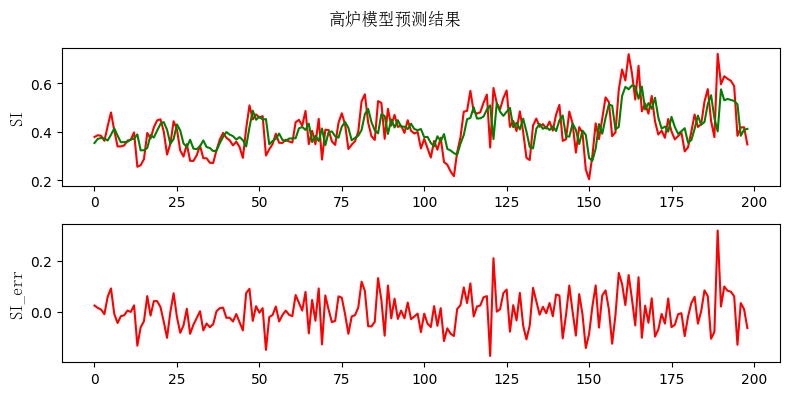

In [30]:
# 模型建模效果
y_pred_0 = my_svr_model.my_predict(X_gaolu_train)
# 计算 RMSE、MRE
y_test = y_gaolu_train
single_control_predict_result(scalers,output_term,y_test,y_pred_0)


RMSE: SI: 0.1070
MRE : SI: 0.1918
MAPE: SI: 19.1847%
MAE:0.0791,RMSE:0.2813,HR:0.7264,RE:0.0493


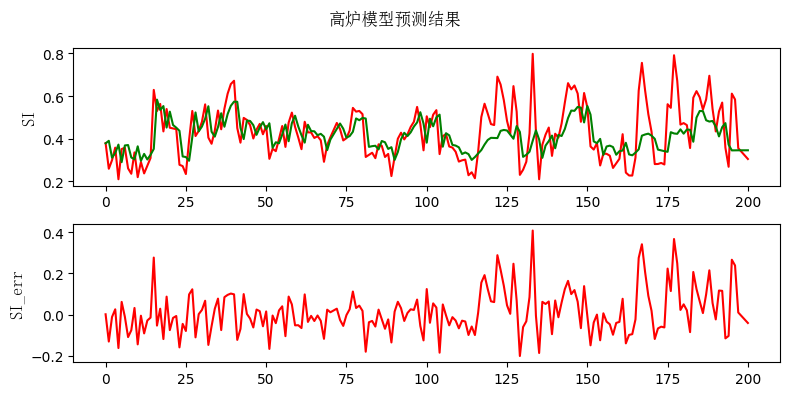

In [31]:
# 模型预测
y_pred_0 = my_svr_model.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
single_control_predict_result(scalers,output_term,y_test,y_pred_0)


In [32]:
# 定义模型
import torch
import torch.nn as nn
import torch.optim as optim

# class MyNeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyNeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.Sigmoid()
#         self.fc2 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x
    
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNeuralNetwork, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU()
        )
        self.fc4 = nn.Sequential(
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x 

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [33]:
epoch_once_time = 30


In [34]:
# 建立高炉模型实例
input_size = 15  # 输入特征大小
hidden_size = 128  # 隐藏层大小
output_size = 1  # 输出大小

# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyNeuralNetwork(input_size, hidden_size, output_size)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


第 30/30 轮, 训练误差: 1.3084, 验证误差: 0.2502
epoch_sum: 30


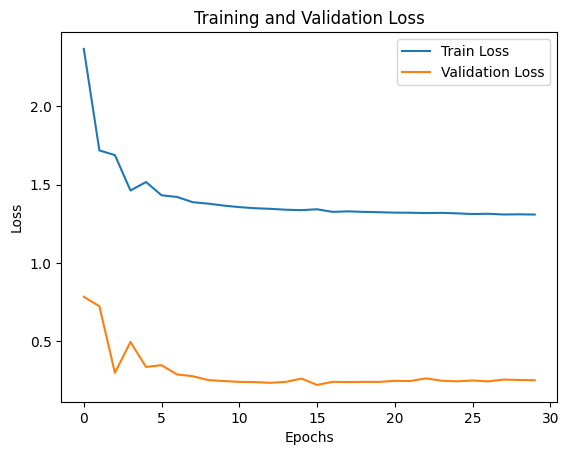

In [35]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=16,
                                    lr = 0.001)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



RMSE: SI: 0.0754
MRE : SI: 0.1560
MAPE: SI: 15.5998%
MAE:0.0600,RMSE:0.2450,HR:0.8442,RE:0.0310


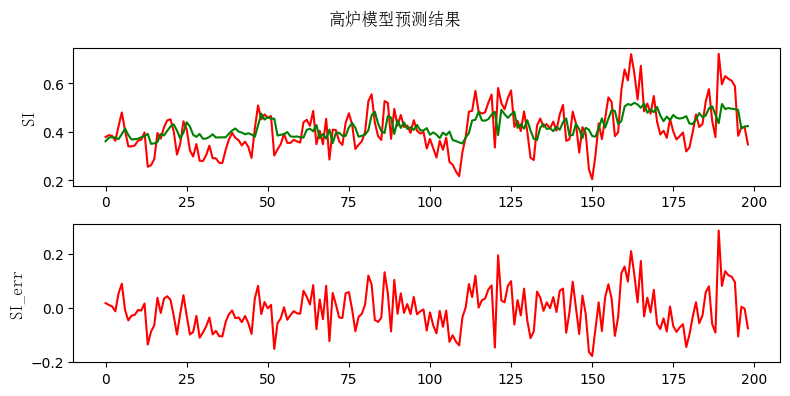

In [36]:
# 高炉模型建模效果
y_pred_0  = model_gaolu.my_predict(X_gaolu_train)
# 计算 RMSE、MRE
y_test = y_gaolu_train
single_control_predict_result(scalers,output_term,y_test,y_pred_0)


RMSE: SI: 0.1146
MRE : SI: 0.2557
MAPE: SI: 25.5724%
MAE:0.0911,RMSE:0.3018,HR:0.6468,RE:0.0566


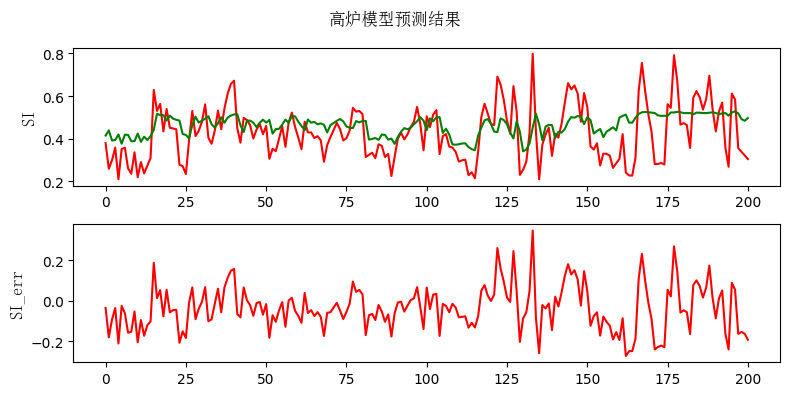

In [37]:
# 高炉模型预测
y_pred_0  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
single_control_predict_result(scalers,output_term,y_test,y_pred_0)
